In [12]:
import pandas as pd
import requests
import networkx as nx
import random
from collections import Counter
import plotly.graph_objects as go

In [13]:
url = "https://crowding.data.tfl.gov.uk/NUMBAT/NUMBAT%202023/NBT23FRI_outputs.xlsx"

r = requests.get(url)
with open("NBT23FRI_outputs.xlsx", "wb") as f:
    f.write(r.content)

xls = pd.ExcelFile("NBT23FRI_outputs.xlsx")
print(xls.sheet_names)

['_Cover', 'Link_Loads', 'Link_Frequencies', 'Line_Boarders', 'Station_Flows', 'Station_Entries', 'Station_Exits', 'Station_Boarders', 'Station_Alighters']


In [14]:
df_links = pd.read_excel(xls, sheet_name="Link_Loads", header=2)
df_flows = pd.read_excel(xls, sheet_name="Station_Flows", header=2)
df_entries = pd.read_excel(xls, sheet_name="Station_Entries", header=2)
df_exits = pd.read_excel(xls, sheet_name="Station_Exits", header=2)
df_boarders = pd.read_excel(xls, sheet_name="Station_Boarders", header=2)
df_alighters = pd.read_excel(xls, sheet_name="Station_Alighters", header=2)

def extract_interchange_stations(df_flows):
    interchange_rows = df_flows[df_flows["Movement"].str.contains("Interchange", na=False)]
    interchange_stations = sorted(interchange_rows["To Station"].dropna().unique())
    return interchange_stations

def build_graph_from_links(df_links, entry_stations=None, exit_stations=None):
    G = nx.DiGraph()
    for _, r in df_links.iterrows():
        G.add_edge(r["From Station"], r["To Station"], weight=r["Total"])
    if len(entry_stations) > 0:
        for station in entry_stations:
            if station not in G:
                G.add_node(station)
    if len(exit_stations) > 0:
        for station in exit_stations:
            if station not in G:
                G.add_node(station)
    return G

def build_entry_weights(df_entries):
    entries = df_entries[["Station", "Total"]].dropna()
    return dict(zip(entries["Station"], entries["Total"]))

def build_exit_weights(df_exits):
    exits = df_exits[["Station", "Total"]].dropna()
    return dict(zip(exits["Station"], exits["Total"]))

def build_board_alight_dicts(df_boarders, df_alighters):
    board_dict = df_boarders.groupby("Station")["Total"].sum().to_dict()
    alight_dict = df_alighters.groupby("Station")["Total"].sum().to_dict()
    return board_dict, alight_dict

def simulate_route(G, start, interchange_list, board_dict, alight_dict,
                   max_steps=5, transfer_prob=0.3):
    path = [start]
    cur = start
    score = 0
    for _ in range(max_steps):
        if cur in interchange_list and random.random() < transfer_prob:
            candidates = [s for s in G.successors(cur) if s in interchange_list and s not in path]
            if candidates:
                nxt = random.choice(candidates)
                path.append(f"[TRANSFER→]{nxt}")
                cur = nxt
                continue

        if cur not in G:
            break
        succ = [s for s in G.successors(cur) if s not in path]
        if not succ:
            break
        weights = [G[cur][s]["weight"] for s in succ]
        cur = random.choices(succ, weights=weights, k=1)[0]
        path.append(cur)
        score += board_dict.get(cur, 0) + alight_dict.get(cur, 0)
    return path, score

def run_simulation_pipeline(df_links, df_flows, df_entries, df_exits, df_boarders, df_alighters,
                            num_routes=10000):
    interchange_stations = extract_interchange_stations(df_flows)
    entry_stations = df_entries["Station"].dropna().unique()
    exit_stations = df_exits["Station"].dropna().unique()
    top_start_stations = df_entries.sort_values(by="Total", ascending=False).head(20)["Station"].tolist()
    top_end_stations = df_exits.sort_values(by="Total", ascending=False).head(20)["Station"].tolist()
    G = build_graph_from_links(df_links, entry_stations, exit_stations)
    entry_weights = build_entry_weights(df_entries)
    exit_weights = build_exit_weights(df_exits)
    board_dict, alight_dict = build_board_alight_dicts(df_boarders, df_alighters)

    starts = list(entry_weights.keys())
    weights = list(entry_weights.values())
    starts = [s for s in starts if s in top_start_stations]
    weights = [entry_weights[s] for s in starts]

    routes = []
    scores = []
    ends = []

    for _ in range(num_routes):
        start = random.choices(starts, weights=weights, k=1)[0]
        path, score = simulate_route(G, start, interchange_stations, board_dict, alight_dict)
        routes.append(path)
        scores.append(score)
        clean_path = [step for step in path if not str(step).startswith("[TRANSFER")]
        end = clean_path[-1] if len(clean_path) >= 2 else None
        ends.append(end)

    df_result = pd.DataFrame({
        "Route": routes,
        "Score": scores,
        "End": ends
    })

    df_result["End Exit Volume"] = df_result["End"].map(exit_weights)

    df_result["Start"] = df_result["Route"].apply(lambda x: x[0] if len(x) > 0 else None)
    df_result["End Clean"] = df_result["End"]
    df_result = df_result[df_result["Start"].isin(top_start_stations) & df_result["End Clean"].isin(top_end_stations)]

    return df_result

def analyze_results(df_result):
    # Top scored routes
    top_routes = df_result.sort_values(by="Score", ascending=False).head(20)

    all_links = []

    for route in df_result["Route"].tolist():
        clean_steps = []
        for step in route:
            if isinstance(step, str) and step.startswith("[TRANSFER→]"):
                clean_steps.append(step.replace("[TRANSFER→]", ""))
            else:
                clean_steps.append(step)
        all_links += [(clean_steps[i], clean_steps[i+1]) for i in range(len(clean_steps)-1) if clean_steps[i] != clean_steps[i + 1]]

    pair_counts = Counter(all_links)
    df_pairs = pd.DataFrame(pair_counts.items(), columns=["Step-Step", "Count"]).sort_values(by="Count", ascending=False)

    top_links = df_pairs.head(20)
    sources = [pair[0] for pair in top_links["Step-Step"]]
    targets = [pair[1] for pair in top_links["Step-Step"]]
    values = top_links["Count"].tolist()

    label_list = list(set(sources + targets))
    label_map = {label: idx for idx, label in enumerate(label_list)}
    source_idx = [label_map[s] for s in sources]
    target_idx = [label_map[t] for t in targets]

    sankey_fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=label_list,
        ),
        link=dict(
            source=source_idx,
            target=target_idx,
            value=values,
        ))])
    sankey_fig.update_layout(title_text="Top 20 Simulated Start-End Routes", font_size=10)

    print("\nTop 20 Scored Routes:")
    print(top_routes[["Route", "Score"]].reset_index(drop=True))

    print("\nTop 20 Start-End Pairs:")
    print(df_pairs.head(20).reset_index(drop=True))

    return sankey_fig

In [17]:
df_result = run_simulation_pipeline(
    df_links, df_flows, df_entries, df_exits,
    df_boarders, df_alighters,
    num_routes=10000
)
df_result_sorted = (
    df_result.assign(Route_str=df_result["Route"].apply(str))
    .sort_values(by="Score", ascending=False)
    .drop_duplicates(subset=["Route_str"])
    .drop(columns=["Route_str"])
)
display(df_result_sorted.head())

,Route,Score,End,End Exit Volume,Start,End Clean
3960,"[Leicester Square, Tottenham Court Road, Oxfor...",1.553579e+06,Victoria LU,86723.867825,Leicester Square,Victoria LU
6211,"[Farringdon, Tottenham Court Road, Oxford Circ...",1.483416e+06,King's Cross St. Pancras,122827.765441,Farringdon,King's Cross St. Pancras
9700,"[Leicester Square, Tottenham Court Road, Oxfor...",1.483416e+06,King's Cross St. Pancras,122827.765441,Leicester Square,King's Cross St. Pancras
7714,"[Bond Street, Oxford Circus, Tottenham Court R...",1.482658e+06,Bank and Monument,54480.339957,Bond Street,Bank and Monument
2075,"[Victoria LU, Green Park, Oxford Circus, Totte...",1.453984e+06,Paddington TfL,81178.247349,Victoria LU,Paddington TfL


In [19]:
df_result_sorted.to_csv("top_scored_routes.csv", index=False)

In [20]:
od_pairs = df_result[["Start", "End Clean"]].dropna()
od_pairs.columns = ["Origin", "Destination"]

od_pairs["OD Pair"] = list(zip(od_pairs["Origin"], od_pairs["Destination"]))
top_od = od_pairs["OD Pair"].value_counts().head(30).reset_index()
top_od.columns = ["OD Pair", "Count"]

top_od["Start"] = top_od["OD Pair"].apply(lambda x: x[0])
top_od["End"] = top_od["OD Pair"].apply(lambda x: x[1])
top_od = top_od[["Start", "End", "Count"]]

top_od.to_csv("top_30_od_pairs.csv", index=False)

In [21]:
fig = analyze_results(df_result)
fig.show()


Top 20 Scored Routes:
                                                Route         Score
0   [Leicester Square, Tottenham Court Road, Oxfor...  1.553579e+06
1   [Farringdon, Tottenham Court Road, Oxford Circ...  1.483416e+06
2   [Leicester Square, Tottenham Court Road, Oxfor...  1.483416e+06
3   [Bond Street, Oxford Circus, Tottenham Court R...  1.482658e+06
4   [Victoria LU, Green Park, Oxford Circus, Totte...  1.453984e+06
5   [Farringdon, Tottenham Court Road, Oxford Circ...  1.429866e+06
6   [Bond Street, Green Park, Oxford Circus, Totte...  1.396390e+06
7   [Bond Street, Green Park, Oxford Circus, Totte...  1.396390e+06
8   [Victoria LU, Green Park, Oxford Circus, Totte...  1.396390e+06
9   [Piccadilly Circus, Green Park, Oxford Circus,...  1.396390e+06
10  [Victoria LU, Green Park, Oxford Circus, Totte...  1.396390e+06
11  [Paddington TfL, Bond Street, Tottenham Court ...  1.395854e+06
12  [Liverpool Street LU, Farringdon, Tottenham Co...  1.394702e+06
13  [Bank and Monument, L

To show the chart on GitHub:

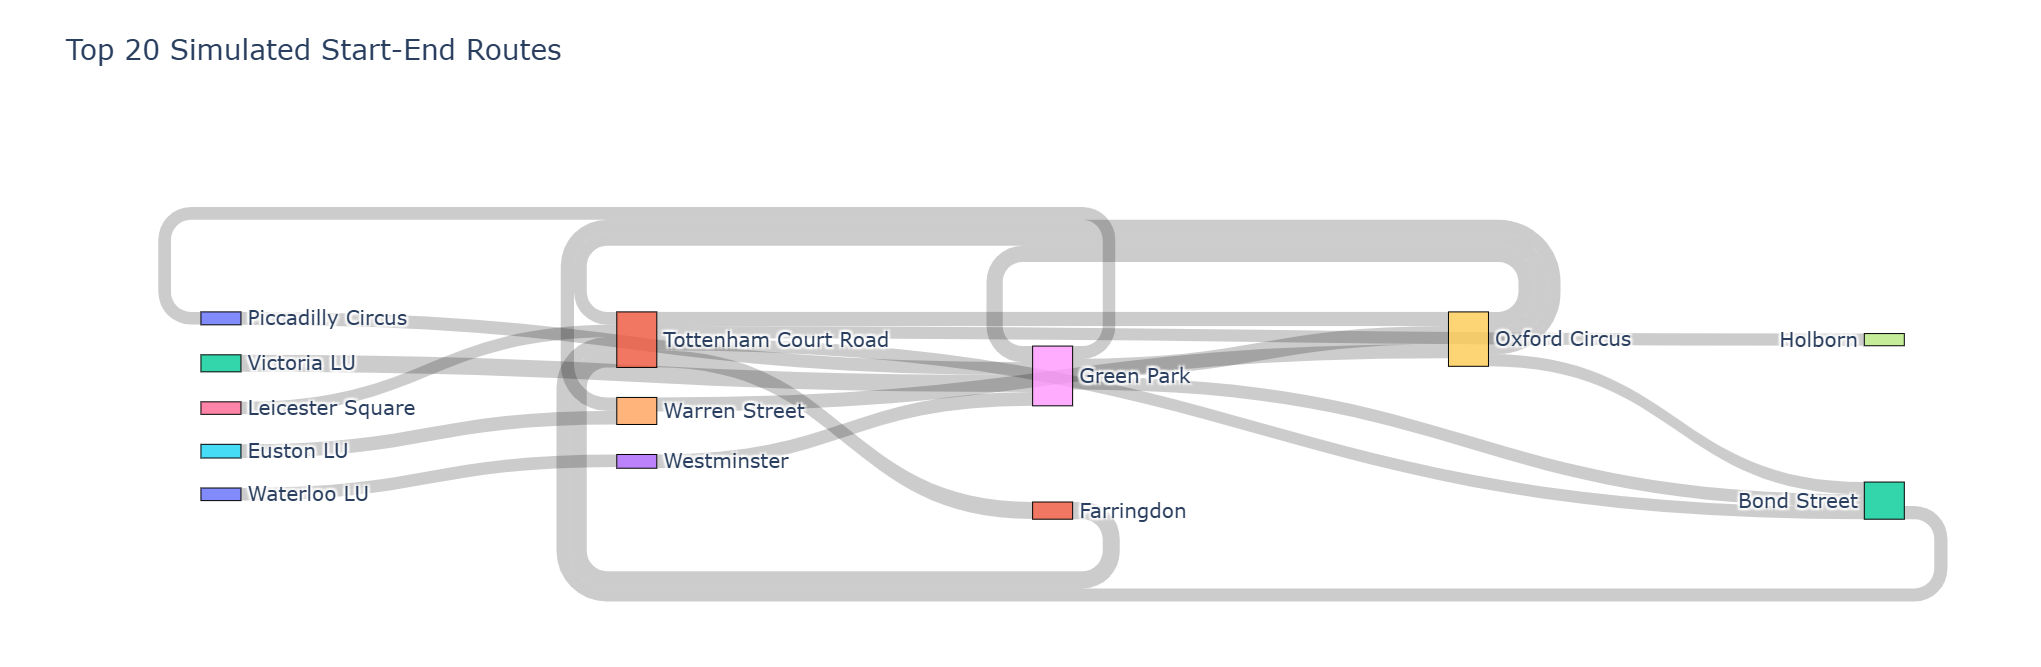